In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.manual_seed(111)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## **Preparing the Training Data**

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 107067799.20it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82630077.64it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36952549.73it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17820887.53it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

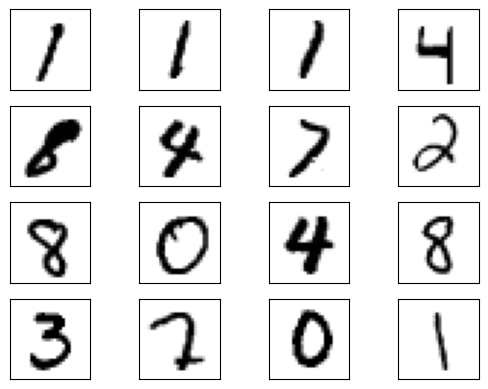

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## **Implementing the Discriminator and the Generator**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

## **Training the Models**

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5692472457885742
Epoch: 0 Loss G.: 0.47791537642478943
Epoch: 1 Loss D.: 0.033507682383060455
Epoch: 1 Loss G.: 4.664132595062256
Epoch: 2 Loss D.: 0.04924694448709488
Epoch: 2 Loss G.: 6.0569353103637695
Epoch: 3 Loss D.: 0.049922775477170944
Epoch: 3 Loss G.: 3.7966771125793457
Epoch: 4 Loss D.: 0.031171895563602448
Epoch: 4 Loss G.: 4.677549362182617
Epoch: 5 Loss D.: 0.044809017330408096
Epoch: 5 Loss G.: 4.837375640869141
Epoch: 6 Loss D.: 0.18939803540706635
Epoch: 6 Loss G.: 3.023841142654419
Epoch: 7 Loss D.: 0.10014118254184723
Epoch: 7 Loss G.: 4.326530456542969
Epoch: 8 Loss D.: 0.12700028717517853
Epoch: 8 Loss G.: 3.115272283554077
Epoch: 9 Loss D.: 0.3417544960975647
Epoch: 9 Loss G.: 2.1571388244628906
Epoch: 10 Loss D.: 0.31888294219970703
Epoch: 10 Loss G.: 1.8504506349563599
Epoch: 11 Loss D.: 0.30574923753738403
Epoch: 11 Loss G.: 2.0286808013916016
Epoch: 12 Loss D.: 0.3690807521343231
Epoch: 12 Loss G.: 1.5546793937683105
Epoch: 13 Loss D.: 0.52

## **Checking the Samples Generated by the GAN**

In [14]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

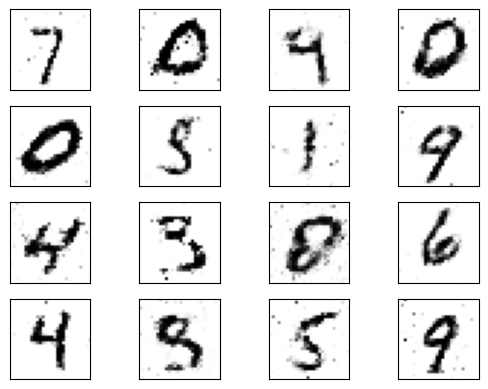

In [15]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])